In [89]:
import yfinance
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from datetime import date, timedelta


In [90]:
start = '2000-01-01'
end = date.today()
ticker = 'AAPL'

In [91]:
df = yfinance.download(ticker, start, end)
print(df.head())
print(df.tail())

[*********************100%%**********************]  1 of 1 completed
                Open      High       Low     Close  Adj Close     Volume
Date                                                                    
2000-01-03  0.936384  1.004464  0.907924  0.999442   0.848323  535796800
2000-01-04  0.966518  0.987723  0.903460  0.915179   0.776801  512377600
2000-01-05  0.926339  0.987165  0.919643  0.928571   0.788168  778321600
2000-01-06  0.947545  0.955357  0.848214  0.848214   0.719961  767972800
2000-01-07  0.861607  0.901786  0.852679  0.888393   0.754065  460734400
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-08-21  175.070007  176.130005  173.740005  175.839996  175.839996   
2023-08-22  177.059998  177.679993  176.250000  177.229996  177.229996   
2023-08-23  178.520004  181.550003  178.330002  181.119995  181.119995   
2023-08-24  180.669998  181.100006  176.009995  17

Text(0, 0.5, 'Prices ($)')

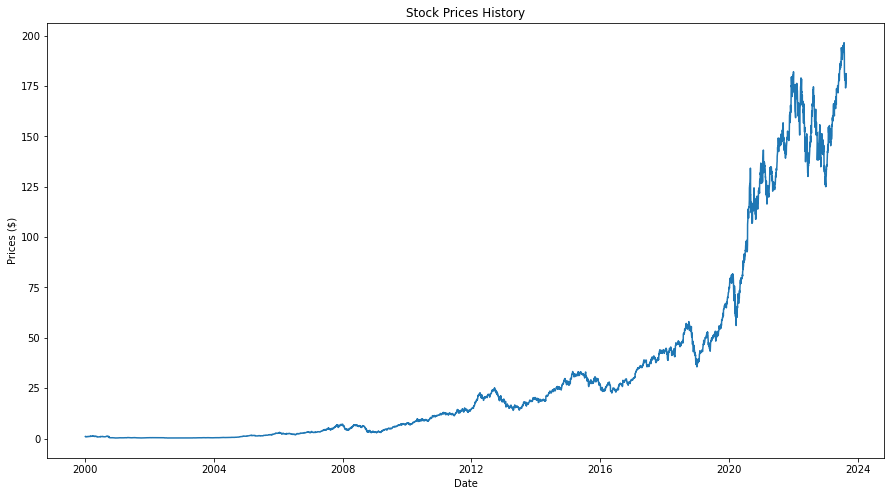

In [92]:
plt.figure(figsize=(15, 8))
plt.title('Stock Prices History')
plt.plot(df['Close'])
plt.xlabel('Date')
plt.ylabel('Prices ($)')

In [93]:
len(df)*0.8

4760.0

In [94]:
data_training = pd.DataFrame(df['Close'][0:int(len(df)*0.80)])
data_testing = pd.DataFrame(df['Close'][int(len(df)*0.80):int(len(df))])

In [95]:
scaler = MinMaxScaler(feature_range=(0,1))
data_training_array = scaler.fit_transform(data_training)

In [96]:
x_train = []
y_train = []

In [97]:
for i in range(60, data_training_array.shape[0]):
    x_train.append(data_training_array[i-60:i])
    y_train.append(data_training_array[i,0])

In [98]:
x_train , y_train = np.array(x_train) , np.array(y_train)

In [99]:
past_60_days = data_training.tail(60)
# final_df= past_60_days.append(data_testing,ignore_index=True)
final_df=pd.concat([past_60_days,data_testing],ignore_index=True)

In [100]:
final_df.shape

(1250, 1)

In [101]:
input_data= scaler.fit_transform(final_df)

In [102]:
x_test=[]
y_test=[]

In [103]:

for i in range(60,input_data.shape[0]):
    x_test.append(input_data[i-60:i])
    y_test.append(input_data[i,0])

In [104]:
x_test , y_test = np.array(x_test) , np.array(y_test)

In [105]:
x_train.shape

(4700, 60, 1)

In [106]:
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60, 100)           40800     
                                                                 
 lstm_3 (LSTM)               (None, 100)               80400     
                                                                 
 dense_2 (Dense)             (None, 25)                2525      
                                                                 
 dense_3 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123751 (483.40 KB)
Trainable params: 123751 (483.40 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [107]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 1, epochs=3)

Epoch 1/3
4700/4700 [==============================] - 107s 22ms/step - loss: 7.6012e-04
Epoch 2/3
4700/4700 [==============================] - 108s 23ms/step - loss: 2.8706e-04
Epoch 3/3
4700/4700 [==============================] - 103s 22ms/step - loss: 2.3392e-04


In [108]:
model.save("lstm.keras")

In [109]:
y_predicted = model.predict(x_test)

38/38 [==============================] - 2s 26ms/step


In [110]:
y_predicted=scaler.inverse_transform(y_predicted)
y_test=y_test.reshape(-1,1)
y_test=scaler.inverse_transform(y_test)


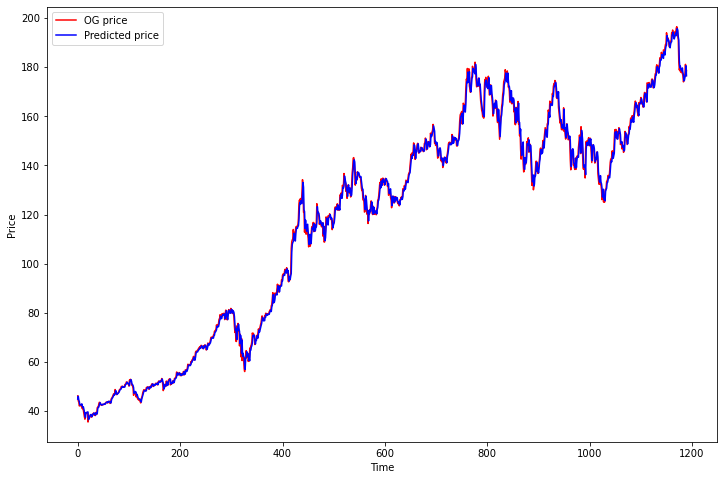

In [111]:
fig2 = plt.figure(figsize=(12,8))
# plt.plot(ff,'b',label='CLosing')
plt.plot(y_test , 'r', label='OG price')
plt.plot(y_predicted , 'b', label='Predicted price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()

In [112]:
from math import sqrt
from sklearn.metrics import mean_squared_error

In [113]:
sqrt(mean_squared_error(y_test,y_predicted))

2.4230180931841194

In [114]:
len(input_data)-60

1190

In [116]:
n_steps=60
pred_days=30
x_input=input_data[len(input_data)-n_steps:].reshape(1,-1)

temp_input=list(x_input[0])
# temp_input=temp_input[0].tolist()


In [117]:
lst_output=[]

In [118]:
i=0
while(i<pred_days):

    if(len(temp_input)>60):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        # print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        # print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        # print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        # print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

predictions=scaler.inverse_transform(lst_output)

In [119]:
from datetime import date, timedelta
future_dates=[]
for i in range(1,31):
    future_dates.append((date.today()+timedelta(days=i)).isoformat()) 
future_dates=pd.to_datetime(future_dates)

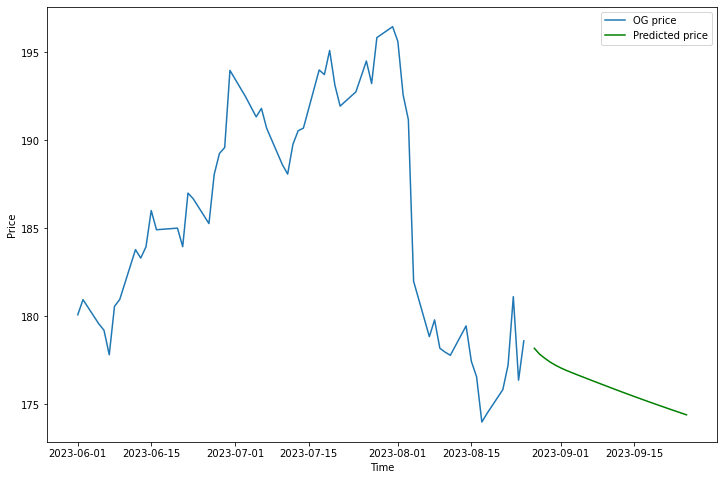

In [121]:
day_new=np.arange(1,61)
day_pred=np.arange(61,61+pred_days)

fig2 = plt.figure(figsize=(12,8))
#plt.plot(ff,'b',label='CLosing')
plt.plot(np.asarray(df[-60:].index),np.asarray(df.Close[-60:]) , label='OG price')
plt.plot(np.asarray(future_dates),np.asarray(predictions) , 'green', label='Predicted price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
